In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats
import seaborn as sns
import pymc3 as pm
import pandas as pd

plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# Understand and Predict the data by Linear regression model

### 4.1 Various Gamma Distributions

Text(0,0.5,'$pdf(x)$')

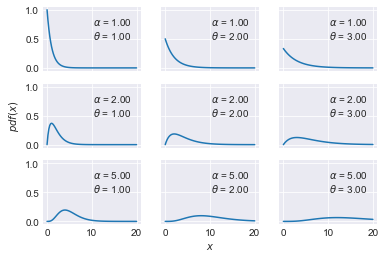

In [3]:
rates = [1, 2, 5]
scales = [1, 2, 3]
x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i, j].plot(x, rv.pdf(x))
        ax[i, j].plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i, j].legend()
        
ax[2, 1].set_xlabel('$x$')
ax[1, 0].set_ylabel('$pdf(x)$')

### 4.2 Create the huristic data using the knowledge about regression line

/Users/tanimu/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'$y$')

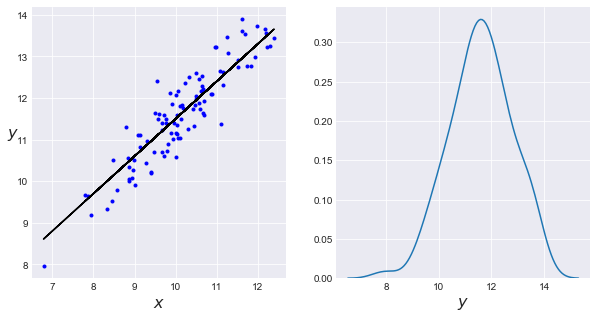

In [4]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1, 2, 2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)

### 4.3 KDE and the trace of the Bayesian Linear Regression's params

In [5]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', 0, sd=10)
    beta = pm.Normal('beta', 0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=alpha + beta * x, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(11000, step, start, njobs=1, chains=1)

logp = -71.578, ||grad|| = 0.14936: 100%|██████████| 36/36 [00:00<00:00, 194.31it/s] 
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 11500/11500 [00:05<00:00, 2052.28it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c23a04dd8>,
      dtype=object)

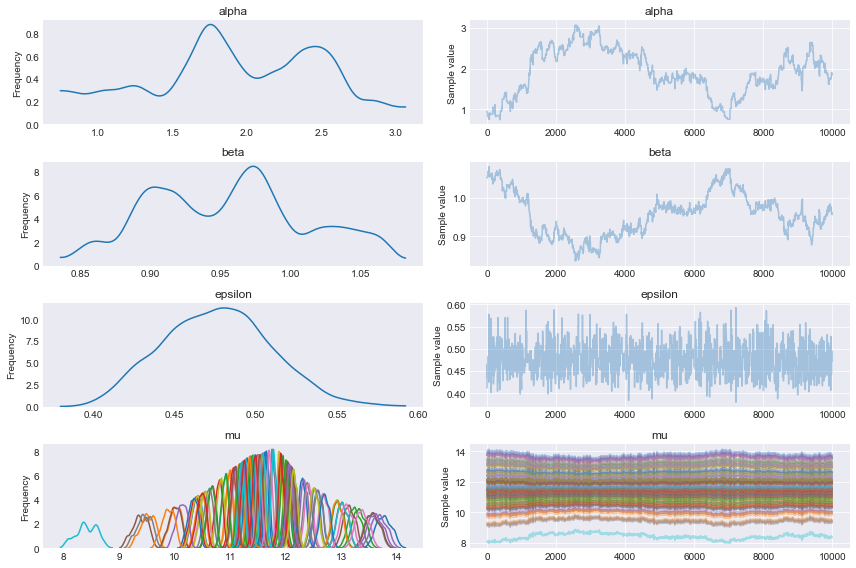

In [6]:
trace_n = trace[1000:]
pm.traceplot(trace_n)

### 4.5 Self correlation of the parameters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c206c15c0>],
      dtype=object)

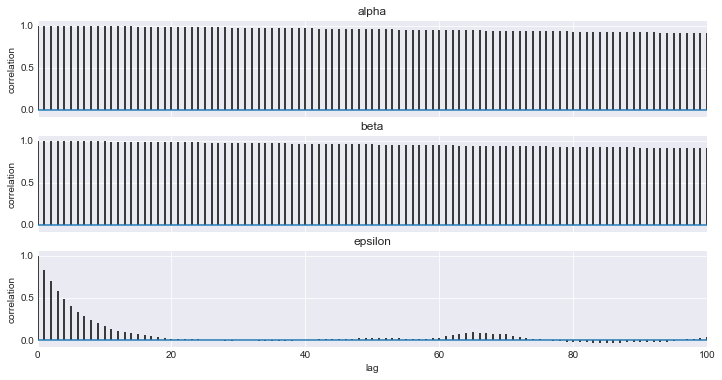

In [7]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace_n, varnames)

### 4.6 KDE of the alpha and beta posterior

/Users/tanimu/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\beta$')

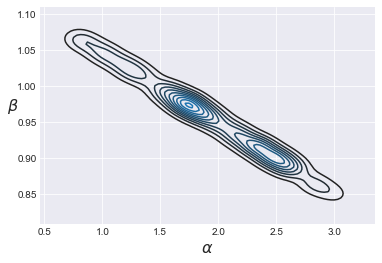

In [8]:
sns.kdeplot(trace_n['alpha'], trace_n['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

### 4.7 Mean Regression Line using mean alpha and mean beta

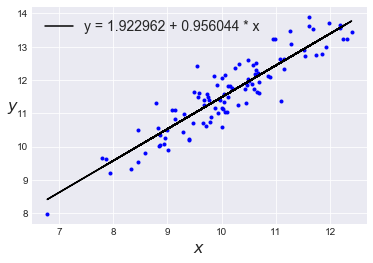

In [9]:
plt.plot(x, y, 'b.');
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:2f} + {:2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

### 4.8 Uncertainty of the Regression Line by mean alpha and mean beta

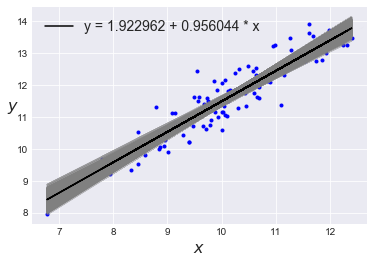

In [10]:
plt.plot(x, y, 'b.');
idx = range(0, len(trace_n['alpha']), 10)
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] * x[:, np.newaxis],
         c='gray', alpha=-0.5);
plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:2f} + {:2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

### 4.9 HPD of the Regression Line

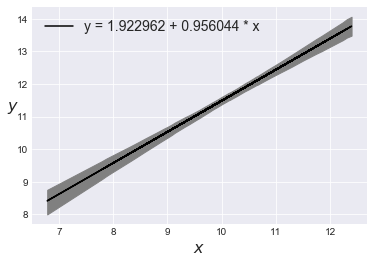

In [11]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:2f} + {:2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_n['mu'], alpha=0.02)[idx]
plt.fill_between(x_ord, sig[:, 0], sig[:, 1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

### 4.10 95% and 50% HPD of the predicted data by the linear regression model

In [12]:
ppc = pm.sample_ppc(trace_n, samples=1000, model=model)

100%|██████████| 1000/1000 [00:01<00:00, 592.40it/s]


Text(0,0.5,'$y$')

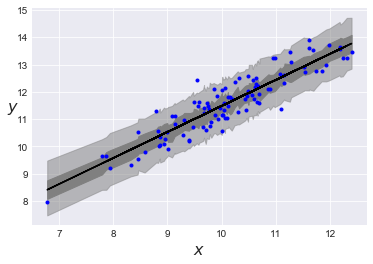

In [13]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:2f} + {:2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

### 4.15 KDE and the race of the Pearson correlation between means and standard deviations

/Users/tanimu/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/tanimu/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/tanimu/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecat

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c349cd160>,
      dtype=object)

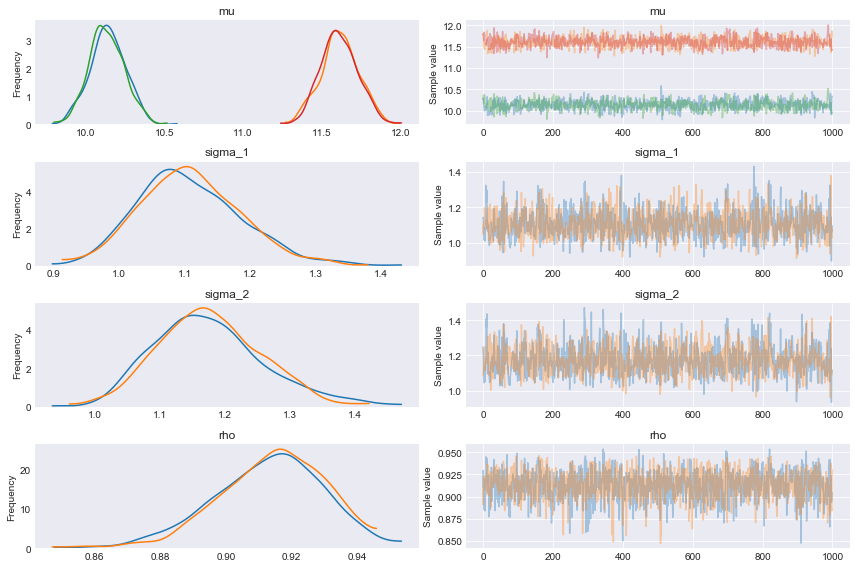

In [16]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

data = np.stack((x, y)).T

with pm.Model() as pearson_model:
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    sigma_1 = pm.HalfNormal('sigma_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_p = pm.sample(1000, step=step, start=start, njobs=1)
    
pm.traceplot(trace_p)